# Machine Learning in Python - Project 1

*Contributors: Rachel Dance, Cecilia Hernandez-Vargas, Finlay Young*

## 0. Setup
The following packages are required to run this notebook

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Modules to install: 
# Display plots inline
%matplotlib inline 

#Import Functions file to avoid code in notebook
import ml_functions

# Data libraries
import pandas as pd
import numpy as np
from numpy.random import uniform

import copy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


## 1. Introduction

Analysis of the data held on NBC Universal's series the Office is performed in order to provide advice to NBC Universal, on the best way in which to produce a special reunion episode. The data 'the_office.csv' is used as provided. We have included no other datasets that that given to us in 'the_office.csv'. Herein we refer to 'the_office.csv' as 'the data'.

In the data, there is a field named 'imdb_rating' which is used as a proxy for success or popularity of an episode. There is also a field 'total_votes' which is used as a secondary proxy for this, as an episode may recieve a rating of 10/10, but that may be the opinion of one or two indviduals. Thererfore,  interms of popularity across the NBC customer base for 'The Office', the combination of these fields is important. The data extracted for this analysis is available publicly, 

In order to extract insight into the dependencies of the 'imdb_rating', we have employed both a linear and polynomial regression models, with regularisation techniques ridge and lasso. These techniques serves to highlight those features of the data which do not contribute to the predictive power.

We saw that the most predictive model out of those tried was a linear regression model, in which we used lasso regularisation. This analysis showed that FEATURE X and FEATURE Y were most significant to the popularity of an episode as measured by our proxies. Therefore our main recommendations to NBC in production of any reuinion episode, should be as follows:
<ol>
<li>Include characters: Dwight, Ering and Angela, these characters 
<li>Ensure as many different characters as possible speak in the episode - there is some correlation with this feature.
<li>Use any director - ther was no preference indicated by the data
<li>Put this episode out as part of a long season as we see that episodes perform better at the end of seasons as opposed to the start
<li>The month of July is a good time to air new episodes as we see higher ratings here in general (by how much?)
</ol>

In [3]:
# Load data into a dataframe - called df by convention
df = pd.read_csv("the_office.csv")

### 1.1 Data cleaning
#### Typos:
The data provided is publicly available, and as expected, there are some discrepencies. In order to have a as 'correct' a dataset as possible, we used "fuzzywuzzy" [https://pypi.org/project/fuzzywuzzy] to correct typos in the names of the directors & writers, in the data. From inspection, some names had one letter incorrect, which was causing them to be seen by the dataframes as a separate unique name, and caused double counting. Using fuzzywuzzy (process) we produced a statistic on how good one entry (string) matches other members of the column. On this basis, we were able to identify errors basedo n the following assumptions:
<ol>
<li>Each erroneous name is no less than a 90% match to its closest match in the column.
<li>Erroneous names appear exactly once.
<li>We do not run this typo cleaner on entries that contain ';' as this corresponds to entries where multiple names are listed.
</ol>
For our purposes, this captures all of our typos although we respect that this will not work for every data set ever - particularly assumption 2. Other methods were also considered namely:
<ol>
<li>Web scraping (using Google & imdb advanced search) - if a name posesses a page on the imdb website which contains an exact match to the spelling of that name, then the name is legitimately a writer or director. This was eliminated on two counts (1) sheer complexity of returning aAccurate* results, and (2) the *correct* names of other directors/actors etc matching the *incorrect* ones in our dataset, e.g. Charles McDougal and Charles McDougall both have pages, and both are legitimate names.
<li>Compare with additional imdb data, "name.basics.tsv.gz" at (https://datasets.imdbws.com/), updated daily - we can compare our names to entries on a list of all possible names in imdb. However, this was eliminated on two counts (1) the dataset was 700MB and computationally infeasible in this case, and (2) the file is also authored by imdb and is likely to *also* contain the error we are trying to find so comparison saw no results.
</ol>

The "typo_clearner function can be fully inspected in the ml_functions.py file. 

In [4]:
ml_functions.typo_cleaner('director',df)
ml_functions.typo_cleaner('writer',df)

/work/ml_functions.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][i] = matches[1][0]
Typo cleaner finished - if no other output, no changes were made
Typo cleaner finished - if no other output, no changes were made


#### Main Characters Column

The column in the data where main charachters in an episode are listed is formatted as a single string, e.g. "Andy;Angela;Dwight;Jim;Michael;Pam;Phyllis;Stanley". This is not indexable so this was split into a 'list of lists', where unique names were identified and dummy columns were created to show whether or not a character appeared in an episode. This effectively performs the 'pandas.get_dummies()' method on all unique entries in all of the lists concurrently. 

In [5]:
df_split_test = copy.deepcopy(df)
# Split the main_chars col into individuals and 
for i in range(len(df_split_test['main_chars'])):
    df_split_test['main_chars'][i] = df_split_test['main_chars'][i].split(';')

#split the actors into columns (dummies)
character_cols = df_split_test.main_chars.apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 Initial analysis pairplot interpretation. 
As a first step, a pairplot was created on the whole dataset as recieved to inspect any obvious features which have a correlations. The pairplot has been omitted as it was only used as a first indication of underlying trends and did not influence the modelling in any tangible way. 

### 2.2 Exploratory Analysis

#### 2.2.1 Ratings skew with season
As the show has aired for 9 seasons, we can see from the data that the average rating has decreased (see red crossed data point) as seasons go on, however this also comes with a vast increase in the varience of ratings given per episode, and reduction in the number of total votes submitted per episode. This is likely due to the popularity of the show itself, and therefore attracting a wider audience. From this observation, we so not expect the "season" feature itself to have an influence on predicting a high rating episode: as we can see here the last season has some of the highest number of votes received, but still a low average rating.

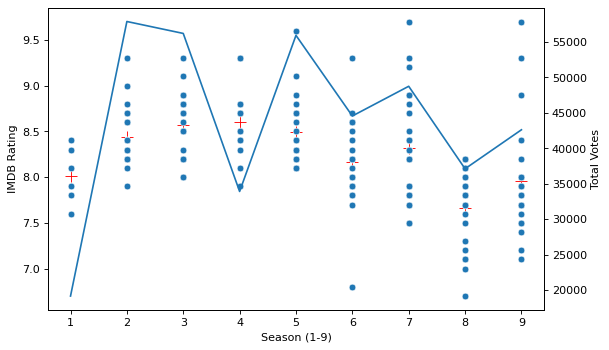

In [6]:
#depends only on df
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.scatterplot(x='season', y='season average imdb rating',data=df.groupby(['season']).agg({ 'imdb_rating':'mean'}).reset_index().rename(columns={'imdb_rating':'season average imdb rating'}),ax = ax1, s=100, color="red", marker="+")
sns.scatterplot(x='season', y='imdb_rating',data=df,ax = ax1)
sns.lineplot(x = 'season', y='total_votes', data=df.groupby(['season']).agg({ 'total_votes':'sum'}).reset_index(), ax = ax2 )
ax1.set_xlabel('Season (1-9)')
ax1.set_ylabel('IMDB Rating')
ax2.set_ylabel('Total Votes')
plt.show()

On this basis, the season feature has been removed. A prediction that the most popular episodes in a particular season may be present in the data, but holds no predictive power for this application. We have chosen to keep the episode number feature as this may indicate to producers whether an episode is likely to be successful following a small or large number of episodes.

#### 2.2.2 Categorial data
##### Characters
There are 3 text columns which are lists of names, and these did not feature in a pairplot analysis. Here, we inspect the character names by finding all unique instances, and apply one hot encoding to allow us to assess these as separate features. We show here how many times each character appears in the dataset.


Text(0.5, 1.0, 'Number of occurrences for each character')

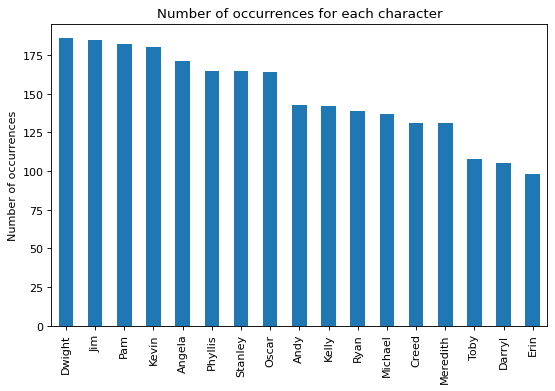

In [7]:
# How many times does each character occur in the data? (df only)
chars = pd.concat([df[['season','episode']],df['main_chars'].str.rsplit(";", n=-1, expand=True)], axis = 1)
melted_chars = chars.melt(id_vars = ['season','episode']).drop('variable',axis = 1).dropna()
melted_chars['value'].value_counts(normalize=False).plot(kind='bar')
plt.ylabel('Number of occurrences')
plt.title('Number of occurrences for each character')

##### Episode names
Further, we have episode names which could potentially be explored using a 'bag of words' analysis to classify episodes into sucessful or not (based on an imdb rating threshold). 
We could also explore the influence of verbs, nouns or adjectives. However, in this study we are are not going to do such analysis, as each of the episodes names is unique and is unlikely to be predictive in itself. Therefore, we drop the column in further analysis.

### 2.3 Feature Engineering

#### Sparse data points

Data which appears sparsely represents a rare event. In the instance where a director (say) is seen only once, they will only appear in *either* the training or the test data, and in only one of the folds where a k-fold method is used. This may cause numerical issues with the modelling and is not deemed to provide any predictive influence. As such, any writer director or character that appears only once in the dataset is removed from the data, as part of feature reduction. 

Further, as it is not possible to draw any correlation between two variables with less than (realistically) 5 datapoints, any writer, director or character that appears less than 5 times is also removed due to lack of predictive power.

#### Other non predictive data points

Conversely, we also observe that some features occur in the data for *every* episode. For example, the character 'Dwight' appears in every episode. A feature that appears in all episodes cannot provide any predictive power, as it represents a constant feature that will not correlate with others.
We have extended this notion and eliminated directors, characters and writers that appear in 95% or *more* of the episodes (i.e. they appear in >176 episodes our of 186) by a similar justification that this also represents a 'constant' features, and any predictive insight is unlikely.
On this basis we delete: the charaters Dwight,Jim,Pam,Kevin; 

In [8]:
df.head()

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...


##### Correlation Matrices

The following correlation matrices are used to give an insight into which features to drop from the model. The matrix below illustrates correlation of our numeric data with imdb_rating. We can see here that the features which are closest to zero are not correlated - we are interested here principally in the imdb_rating.

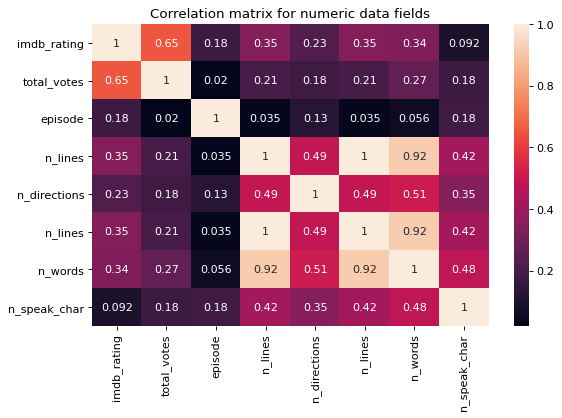

In [9]:
#df only
corrMatrix = df[['imdb_rating','total_votes','episode','n_lines','n_directions','n_lines', 'n_words','n_speak_char']]
ax1 = plt.axes()
sns.heatmap(corrMatrix.corr(), annot=True, ax=ax1) 
ax1.set_title('Correlation matrix for numeric data fields')
plt.show()

The matrix shows that each of these features has either a direct, or secondary correlation with imdb_rating. Therefore we did not choose to delete any of these features.

#### Correlation matrix - characters

The matrix below shows the correlation between imdb_rating and the characters. We can immediately see that the character 'Dwight' has a correlation of 1.0 for imdb_rating as it appears in all episodes, and this is the only character to do this. This reinforces our decision to remove this feature. We also observe that characters Jim,Pam,Kevin have correlation values close to zero. This indicates they have little or no influence on the imdb_rating.

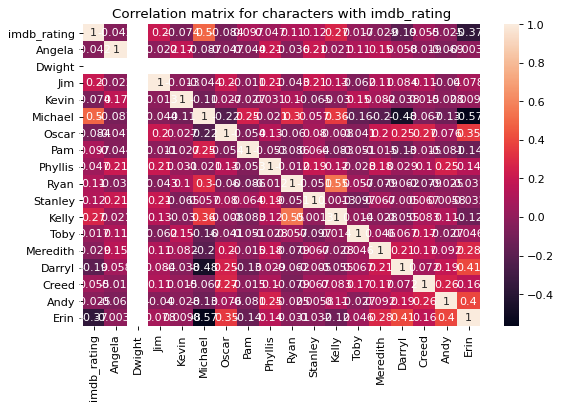

In [10]:
# Correlation between imdb_rating
corrMatrix = pd.concat([df['imdb_rating'], character_cols], axis=1)

ax2 = plt.axes()
sns.heatmap(corrMatrix.corr(), annot=True, ax=ax2) 
ax2.set_title('Correlation matrix for characters with imdb_rating')
plt.show()


#### Correlation Matrices - writer/director
The final correlation matrix we consider is that of writers and directors. This matrix shows broadly that the effect of the writer or director with imdb_rating is small. We see the largest contribution to the rating from the writers Greg Daniels, BLAH and BLAH. All other writers had a much smaller contributions so there are omitted. 
Running this for directors by the same reasoning means that X Y and Z were included in the model.

In [11]:
# Correlation matrix for writer and director - change string at top to chage!
col_list = [col for col in df_model_data.columns if 'writer' in col]
col_list.append('imdb_rating')
col_list
# corrMatrix = df_full.drop(['episode','n_lines','n_directions','n_lines', 'n_words','n_speak_char'], axis=1)
corrMatrix = df_model_data[col_list]

ax3 = plt.axes()
sns.heatmap(corrMatrix.corr(), annot=True, ax=ax3)
ax3.set_title('Correlation matrix for numeric data fields')
plt.show() 


NameError: name 'df_model_data' is not defined

In [12]:
# Function to create a list of writers and directors to delete
to_elim_dirs, to_elim_writers = ml_functions.elim_writers_directors(df_split_test)

# Final list of columns to eliminate in feature engineering steps
to_elim = to_elim_writers + to_elim_dirs + ['Dwight','Jim','Pam','Kevin'] 

# Call function to reformat the date/time data to produce columns for 
# month and day of the week

# def date_and_time(df_full, df_split_test, ccc):
#     df_full = pd.concat([df_split_test, ccc], axis=1)
#     df_full["month"] = df_full["air_date"].str[5:7]
#     df_full['day_of_week'] = pd.to_datetime(df_full['air_date']).dt.dayofweek
#     days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

#     df_full['day_of_week'] = df_full['day_of_week'].apply(lambda x: days[x])
    
#     return df_full

# ml_functions.date_and_time(df_full, df_split_test, character_cols)


/work/ml_functions.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_dirs['director'] = 'director_' + single_dirs['director'].astype(str)
/work/ml_functions.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_writers['writer'] = 'writer_' + single_writers['writer'].astype(str)


In [15]:
df_full = pd.concat([df_split_test, character_cols], axis=1)
df_full["month"] = df_full["air_date"].str[5:7]

df_full['day_of_week'] = pd.to_datetime(df_full['air_date']).dt.dayofweek

days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

df_full['day_of_week'] = df_full['day_of_week'].apply(lambda x: days[x])

df_full.drop(['season', 'air_date','main_chars','episode_name'], axis = 1, inplace=True)

# # Concatenate the dataframes where actors are already split, remove duplicates 
# df_full = pd.concat([df_split_test.drop(['season', 'air_date','main_chars','episode_name'], axis= 1), character_cols], axis=1)

df_full_dummies = pd.get_dummies(df_full)
# df_full_dummies.columns 
df_model_data = df_full_dummies.drop(to_elim, axis=1) 
df_model_data.columns
#cols 0:6 numerical, cols [6:] - cetegorical


Index(['episode', 'imdb_rating', 'total_votes', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'Angela', 'Michael', 'Oscar', 'Phyllis',
       'Ryan', 'Stanley', 'Kelly', 'Toby', 'Meredith', 'Darryl', 'Creed',
       'Andy', 'Erin', 'director_B.J. Novak', 'director_Charles McDougall',
       'director_David Rogers', 'director_Greg Daniels',
       'director_Jeffrey Blitz', 'director_Ken Kwapis',
       'director_Ken Whittingham', 'director_Matt Sohn', 'director_Paul Feig',
       'director_Paul Lieberstein', 'director_Randall Einhorn',
       'writer_Aaron Shure', 'writer_B.J. Novak', 'writer_Brent Forrester',
       'writer_Charlie Grandy', 'writer_Daniel Chun',
       'writer_Gene Stupnitsky;Lee Eisenberg', 'writer_Greg Daniels',
       'writer_Jennifer Celotta', 'writer_Justin Spitzer',
       'writer_Lee Eisenberg;Gene Stupnitsky', 'writer_Michael Schur',
       'writer_Mindy Kaling', 'writer_Paul Lieberstein', 'month_01',
       'month_02', 'month_03', 'month_04', 'm

## Train model

In [16]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

In [17]:
def dataframe_prep(dataframe,col_predicted:str):
    '''
    Create inputs X dataframe, outputs y dataframe, and split the data using test_train_split from sklearn
    inputs: dataframe = dataframe to be modelled
            col_predicted
    '''
    # Lose the columns we are predicting from inputs X, and write this to outputs y
    X = dataframe.drop(col_predicted, axis = 1)
    y = dataframe[col_predicted]

    # Test train split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    return X_train, X_test, y_train, y_test

## Linear regression

In [18]:
def run_linear_regression(dataframe):
    '''
    Run standard linear regression
    Function immediately drops the column we are predicting (TODO: have this as an input string)
    input: dataframe on which you wish to run linea regression
            where all features are dummies, i.e. 0/1
    '''
    
    X_train, X_test, y_train, y_test = dataframe_prep(dataframe,'imdb_rating')

    #lm = LinearRegression().fit(X_train, y_train)
    #model_fit(lm, X_test, y_test, plot=True)
    #print("number of coefficients:",len(get_coefs(lm)))

    first = make_pipeline(
            LinearRegression(fit_intercept = False)
        )

    parameters = {'linearregression__normalize': [True,False]}

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    #this is the name you must change for each dataframe
    first_grid = GridSearchCV(first,parameters,  cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)

    #==Print the results========
    print("best index: ", first_grid.best_index_) #position of the array of the degree
    print("best param: ", first_grid.best_params_)
    print("best neg_root_mean_squared_error (score): ", first_grid.best_score_ *-1)
    print("number of coefficients:", len(first_grid.best_estimator_.named_steps['linearregression'].coef_))

    y_hat = first_grid.predict(X_test)
    model_fit(first_grid, X_test, y_test, plot=True)
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)

    print('rmse_test == ', rmse_test)
    print('rmse_train == ', rmse_train)
    print(first_grid.best_estimator_.named_steps['linearregression'].coef_)
    print("intercept == ",first_grid.best_estimator_.named_steps['linearregression'].intercept_)

    res = pd.DataFrame(
            data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
        )
    
    return res,rmse_train,rmse_test

best index:  0
best param:  {'linearregression__normalize': True}
best neg_root_mean_squared_error (score):  0.449948663068153
number of coefficients: 55


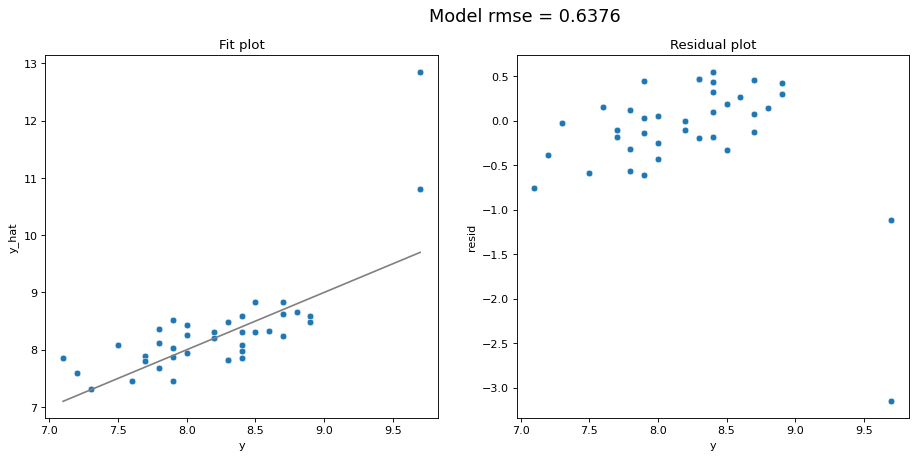

rmse_test ==  0.6376310195040373
rmse_train ==  0.0
[ 3.84012109e-02  6.91241962e-04  8.70990313e-04 -1.43293586e-03
  3.66568146e-05  1.06068700e-03 -9.84985579e-02  1.79538575e-01
  7.90118912e-02 -6.52390743e-02 -3.25494380e-01  1.69329223e-01
  2.36926424e-01 -1.40927978e-02  4.14036347e-02 -7.31338402e-03
 -4.22621355e-02  1.64108454e-01  9.81946753e-03 -1.82533788e-01
  1.87287866e-02 -1.29970427e-01 -1.79194454e-02 -2.48748243e-01
 -2.17422371e-01 -1.20581664e-01  2.73677627e-02 -1.72016710e-01
 -2.31902416e-01 -1.13808851e-01 -2.33273120e-01  9.56251805e-02
  9.67734429e-02 -1.91836701e-01  1.48081474e-01 -1.43581715e-02
  4.50567058e-02 -5.89718055e-02  6.57059520e-02  1.04174255e-01
  1.37284693e-01  7.24711998e-02  1.41652565e-01  1.25487598e+00
  1.12606527e+00  8.86410032e-01  1.03542431e+00  1.20457251e+00
  1.79067016e+00  1.48069236e+00  1.52052163e+00  1.50388712e+00
  2.84028558e+00  4.50920161e+00  4.45363217e+00]
intercept ==  0.0


In [19]:
# Run the linear reg for dataframe df_model_data (one with directors missing etc)
lin_reg,rmse_train_lin_reg,rmse_test_lin_reg = run_linear_regression(df_model_data)
#rmse_train_lin_reg_df_model_data

### Linear regression with standardisation

In [21]:
def run_linear_regr_standardisation(dataframe):
    '''
    Linear regression model with standardisation

    '''
    # Lose the columns we are predicting from inputs X, and write this to outputs y
    X = dataframe.drop('imdb_rating', axis = 1)
    y = dataframe["imdb_rating"]

    # Test train split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    first_2 = make_pipeline(
            StandardScaler(),
            LinearRegression(fit_intercept = False)
        )

    parameters = {'linearregression__normalize': [True,False]}

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    first2_grid = GridSearchCV(first_2,parameters,  cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)


    print("best index: ", first2_grid.best_index_) #position of the array of the degree
    print("best param: ", first2_grid.best_params_)
    print("best score: ", first2_grid.best_score_ *-1)
    print("number of coefficients:",len(first2_grid.best_estimator_.named_steps['linearregression'].coef_))

    y_hat = first2_grid.predict(X_test)
    model_fit(first2_grid, X_test, y_test, plot=True) #compute over test
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)

    print('rmse_test == ', rmse_test)
    print('rmse_train == ', rmse_train)
    print(first2_grid.best_estimator_.named_steps['linearregression'].coef_)
    print("intercept == ",first2_grid.best_estimator_.named_steps['linearregression'].intercept_)

    res = pd.DataFrame(
            data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
        )

    return res, rmse_train, rmse_test

In [22]:
#lin_reg_stand, rmse_train_lin_stand, rmse_test_lin_stand = run_linear_regr_standardisation(df_model_data)


## Polynomial regression with no interaction

In [23]:
def run_poly_noint(dataframe):
    '''
    Linear regression model with standardisation

    '''
    # Lose the columns we are predicting from inputs X, and write this to outputs y
    X = dataframe.drop('imdb_rating', axis = 1)
    y = dataframe["imdb_rating"]

    # Test train split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    fffirst_2 = make_pipeline(
            make_column_transformer(
                (PolynomialFeatures(include_bias = False), ['episode']),
                (PolynomialFeatures(include_bias = False), ['total_votes']),
                (PolynomialFeatures(include_bias = False), ['n_lines']),
                (PolynomialFeatures(include_bias = False), ['n_directions']),
                (PolynomialFeatures(include_bias = False), ['n_words']),
                (PolynomialFeatures(include_bias = False), ['n_speak_char']),
                remainder = 'passthrough'
            ),
            LinearRegression(fit_intercept=False)
        )

    parameters = {
        'columntransformer__polynomialfeatures-1__degree': np.arange(1,3,1),
        'columntransformer__polynomialfeatures-2__degree': np.arange(1,3,1),
        'columntransformer__polynomialfeatures-3__degree': np.arange(1,3,1),
        'columntransformer__polynomialfeatures-4__degree': np.arange(1,3,1),
        'columntransformer__polynomialfeatures-5__degree': np.arange(1,3,1),
        'columntransformer__polynomialfeatures-6__degree': np.arange(1,3,1)

    }

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    fffirst2_grid = GridSearchCV(fffirst_2, parameters,  cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)

    print("best index: ", fffirst2_grid.best_index_) #position of the array of the degree
    print("best param: ", fffirst2_grid.best_params_)
    print("best score: ", fffirst2_grid.best_score_ *-1)
    print("number of coefficients:",len(fffirst2_grid.best_estimator_.named_steps['linearregression'].coef_))

    y_hat = fffirst2_grid.predict(X_test)
    model_fit(fffirst2_grid, X_test, y_test, plot=True) #compute over test
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)

    print('rmse_test == ', rmse_test)
    print('rmse_train == ', rmse_train)
    print(fffirst2_grid.best_estimator_.named_steps['linearregression'].coef_)
    print("intercept == ",fffirst2_grid.best_estimator_.named_steps['linearregression'].intercept_)

    res = pd.DataFrame(
                data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
            )
    
    return res, rmse_train, rmse_test


best index:  32
best param:  {'columntransformer__polynomialfeatures-1__degree': 2, 'columntransformer__polynomialfeatures-2__degree': 1, 'columntransformer__polynomialfeatures-3__degree': 1, 'columntransformer__polynomialfeatures-4__degree': 1, 'columntransformer__polynomialfeatures-5__degree': 1, 'columntransformer__polynomialfeatures-6__degree': 1}
best score:  0.4465205164766986
number of coefficients: 56


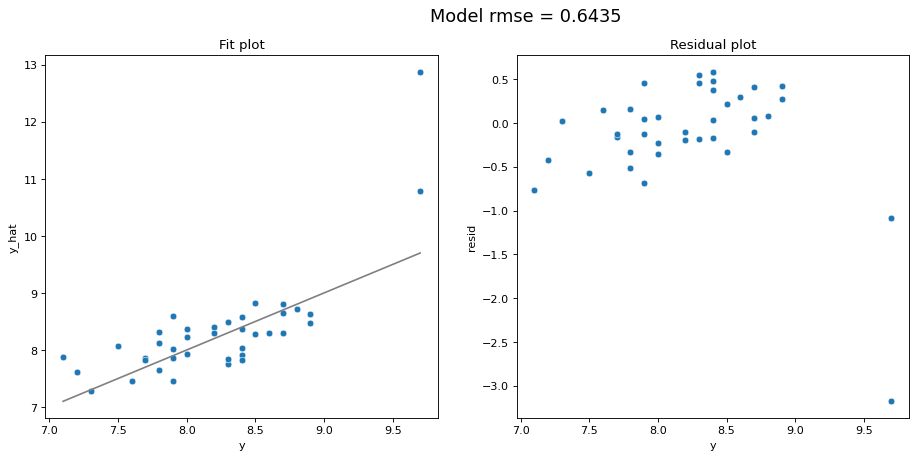

rmse_test ==  0.64345211643746
rmse_train ==  0.0
[ 7.73678996e-02 -1.40461085e-03  6.95025119e-04  8.06781296e-04
 -1.46864758e-03  4.42148985e-05 -1.62272120e-04 -9.96426428e-02
  1.88481084e-01  6.54873903e-02 -7.93558723e-02 -3.22641271e-01
  1.74027194e-01  2.41418761e-01 -2.02706118e-02  4.18975931e-02
 -1.48117166e-02 -5.35155480e-02  1.64466401e-01  4.95236421e-02
 -2.02893047e-01 -2.35837425e-02 -1.43257421e-01 -1.87014795e-02
 -2.73058587e-01 -1.56894303e-01 -1.07373370e-01  1.07417730e-02
 -1.77315377e-01 -2.51722137e-01 -1.25889600e-01 -2.32044205e-01
  8.52637018e-02  9.21201830e-02 -1.88684394e-01  1.32510869e-01
 -5.65734516e-02  1.60337399e-02 -6.65125565e-02  5.66670277e-02
  8.11772016e-02  1.68427422e-01  5.28152748e-02  1.49872950e-01
  1.15049197e+00  1.00149576e+00  8.23751807e-01  1.00087985e+00
  1.22245634e+00  1.90488262e+00  1.48572004e+00  1.44615343e+00
  1.42484737e+00  2.74189991e+00  4.37954328e+00  4.33923599e+00]
intercept ==  0.0


In [24]:
poly_reg_noint, rmse_train_poly_reg_noint, rmse_test_poly_reg_noint = run_poly_noint(df_model_data)



## Polynomial regression

In [25]:
def run_polynomial_regression(dataframe):
    '''
    Run the polynomial regression model 
    '''

    # Lose the columns we are predicting from inputs X, and write this to outputs y
    X = dataframe.drop('imdb_rating', axis = 1)
    y = dataframe["imdb_rating"]

    # Test train split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    second = make_pipeline(
            PolynomialFeatures(),
            LinearRegression(fit_intercept = False)
        )

    parameters = {
        'polynomialfeatures__degree': np.arange(1,3,1),
        'linearregression__normalize': [True,False]
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    second_grid = GridSearchCV(second, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
    print("best index: ", second_grid.best_index_) #position of the array of the degree
    print("best param: ", second_grid.best_params_)
    print("best score: ", second_grid.best_score_ *-1)
    print("number of coefficients:",len(second_grid.best_estimator_.named_steps['linearregression'].coef_))

    y_hat = second_grid.predict(X_test)
    model_fit(second_grid, X_test, y_test, plot=True)
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)

    print('rmse_test == ', rmse_test)
    print('rmse_train == ', rmse_train)
    print(second_grid.best_estimator_.named_steps['linearregression'].coef_)
    print("intercept == ",second_grid.best_estimator_.named_steps['linearregression'].intercept_)

    res = pd.DataFrame(
            data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
        )

    return res, rmse_train, rmse_test

best index:  0
best param:  {'linearregression__normalize': True, 'polynomialfeatures__degree': 1}
best score:  0.41230690129128716
number of coefficients: 56


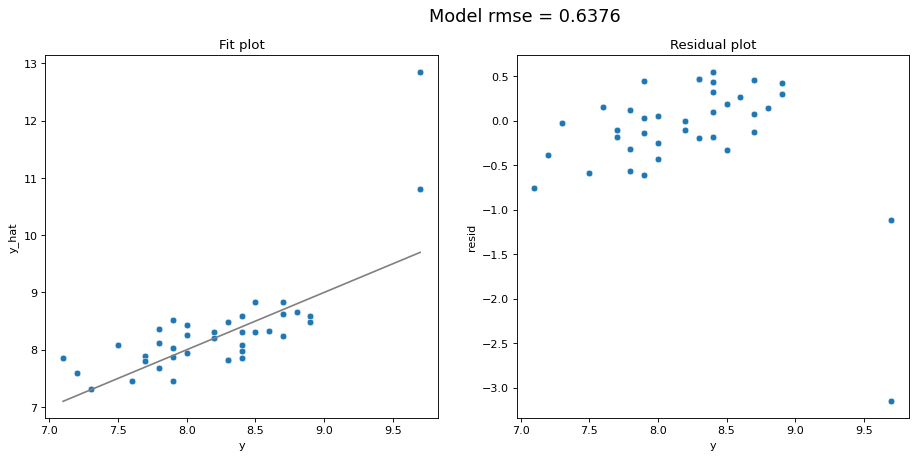

rmse_test ==  0.6376310195036851
rmse_train ==  0.0
[ 3.63172903e+00  3.84012109e-02  6.91241962e-04  8.70990313e-04
 -1.43293586e-03  3.66568146e-05  1.06068700e-03 -9.84985579e-02
  1.79538575e-01  7.90118912e-02 -6.52390743e-02 -3.25494380e-01
  1.69329223e-01  2.36926424e-01 -1.40927978e-02  4.14036347e-02
 -7.31338402e-03 -4.22621355e-02  1.64108454e-01  9.81946753e-03
 -1.82533788e-01  1.87287866e-02 -1.29970427e-01 -1.79194454e-02
 -2.48748243e-01 -2.17422371e-01 -1.20581664e-01  2.73677627e-02
 -1.72016710e-01 -2.31902416e-01 -1.13808851e-01 -2.33273120e-01
  9.56251805e-02  9.67734429e-02 -1.91836701e-01  1.48081474e-01
 -1.43581715e-02  4.50567058e-02 -5.89718055e-02  6.57059520e-02
  1.04174255e-01  1.37284693e-01  7.24711998e-02  1.41652565e-01
  3.46943720e-01  2.18133011e-01 -2.15222265e-02  1.27492053e-01
  2.96640251e-01  8.82737900e-01  5.72760097e-01  6.12589371e-01
  5.95954858e-01  1.16488807e-01  1.78540483e+00  1.72983540e+00]
intercept ==  0.0


In [26]:
poly_reg, rmse_train_poly_reg, rmse_test_poly_reg= run_polynomial_regression(df_model_data)


## Lasso 

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0667510001447253, tolerance: 0.8094089999999998
  positive)


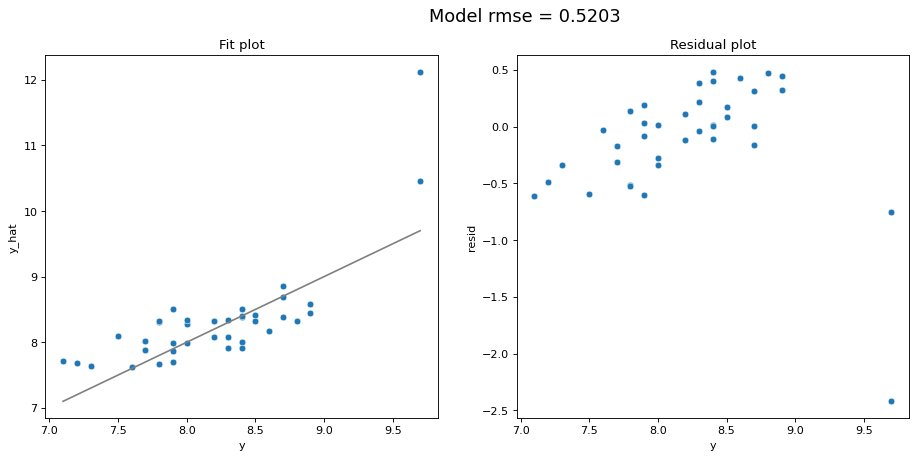

In [30]:
def run_lasso_(dataframe):
    '''
    Run Lasso... 

    '''
    
    # Lose the columns we are predicting from inputs X, and write this to outputs y
    X = dataframe.drop('imdb_rating', axis = 1)
    y = dataframe["imdb_rating"]

    # Test train split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    alpha_list = np.linspace(0.01, 15, num=100)

    third = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(),
            Lasso(fit_intercept= False)
        )

    parameters = {
        'polynomialfeatures__degree': np.arange(1,3,1),
        'lasso__alpha': alpha_list,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    third_grid = GridSearchCV(third, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
    
    y_hat = third_grid.predict(X_test)
    model_fit(third_grid, X_test, y_test, plot=True)
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)
    
    results = pd.DataFrame(
        data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
    )
    
    return third_grid, rmse_train, rmse_test, results


model, lasso_rmse_train, lasso_rmse_test, results_table = run_lasso_(df_model_data)



In [31]:
#def results_lasso(model):

print("best param: ", model.best_params_)
print("best score: ", model.best_score_ *-1)
print("number of coefficients:",len(model.best_estimator_.named_steps["lasso"].coef_))

print('rmse_test == ', lasso_rmse_test)
print('rmse_train == ', lasso_rmse_train)

print("coefficients == ", model.best_estimator_.named_steps["lasso"].coef_)
print("intercept == ", model.best_estimator_.named_steps["lasso"].intercept_)

results_table


best param:  {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1}
best score:  0.38235067661304317
number of coefficients: 56
rmse_test ==  0.5202864106119595
rmse_train ==  0.0
coefficients ==  [ 8.25013514e+00  9.52548913e-02  3.46641846e-01  9.73973030e-02
  0.00000000e+00  0.00000000e+00  1.72293408e-02 -2.16970351e-02
  8.65040255e-02  0.00000000e+00 -0.00000000e+00 -9.27915669e-02
  1.07337093e-02  9.19472122e-02  0.00000000e+00  2.33816983e-03
 -0.00000000e+00  0.00000000e+00  2.83157082e-02 -0.00000000e+00
 -3.86528904e-05  1.98557706e-02 -5.33276623e-03  1.66983779e-02
 -2.67364168e-02 -1.57257292e-02 -9.83599385e-03 -0.00000000e+00
 -0.00000000e+00 -7.77884286e-03 -6.11431129e-03 -3.63998764e-02
  4.79956676e-04  1.18988961e-02 -8.00506109e-03  7.82853678e-03
 -0.00000000e+00  0.00000000e+00 -1.52607790e-03  1.40815159e-02
  0.00000000e+00  0.00000000e+00  6.68837134e-03  0.00000000e+00
 -0.00000000e+00 -1.33788732e-02 -6.68846668e-02 -6.48407025e-03
  4.65008890e-02  5.61

,y,y_hat,resid
106,8.4,8.384924,0.0
45,8.9,8.577038,0.3
158,7.2,7.685957,-0.5
63,7.9,8.503321,-0.6
135,9.7,10.456779,-0.8
66,8.3,7.918583,0.4
18,8.3,8.335011,-0.0
109,8.6,8.175420,0.4
141,7.3,7.634256,-0.3
7,8.2,8.319642,-0.1


In [ ]:
N = len(df_model_data)
p = len(df_model_data.columns)  #doesnt include intercept

X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
#X_with_intercept[:, 0] = 1

X_with_intercept[:, 0:p] = df_model_data.values
X_with_intercept


array([[1.000e+00, 7.600e+00, 3.706e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 8.300e+00, 3.566e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.000e+00, 7.900e+00, 2.983e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [2.100e+01, 8.900e+00, 2.041e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.200e+01, 9.300e+00, 2.860e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.400e+01, 9.700e+00, 7.934e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [ ]:
RSS = table['resid']**2. sum()
RSS

SyntaxError: invalid syntax (<ipython-input-25-f37c89e7be22>, line 1)

In [ ]:
#y_hat = model.predict(X)
#residuals = y.values - y_hat
N = len(df_model_data)
p = len(df_model_data.columns) #doesnt include intercept
RSS = table['resid']**2. sum()
residual_sum_of_squares = residuals.T @ residuals
residual_sum_of_squares[0,0]
#sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
#var_beta_hat = sigma_squared_hat * np.linalg.inv(X_with_intercept.T @ X_with_intercept)  
#for p_ in range(p):
 #   standard_error = var_beta_hat[p_, p_] ** 0.5
  #  print(f"SE(beta_hat[{p_}]): {standard_error}")

IndexError: invalid index to scalar variable.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0667510001447253, tolerance: 0.8094089999999998
  positive)
best index:  0
best param:  {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1}
best score:  0.38235067661304317
number of coefficients: 56


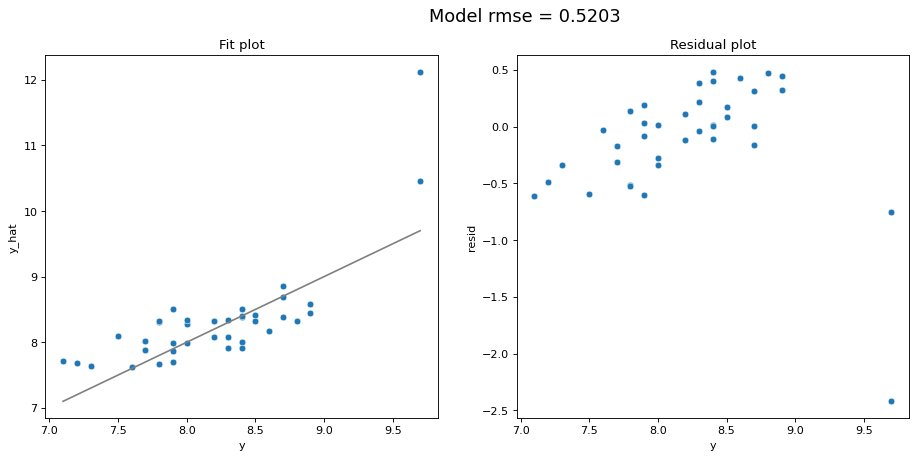

rmse_test ==  0.5202864106119595
rmse_train ==  0.0
coefficients ==  [ 8.25013514e+00  9.52548913e-02  3.46641846e-01  9.73973030e-02
  0.00000000e+00  0.00000000e+00  1.72293408e-02 -2.16970351e-02
  8.65040255e-02  0.00000000e+00 -0.00000000e+00 -9.27915669e-02
  1.07337093e-02  9.19472122e-02  0.00000000e+00  2.33816983e-03
 -0.00000000e+00  0.00000000e+00  2.83157082e-02 -0.00000000e+00
 -3.86528904e-05  1.98557706e-02 -5.33276623e-03  1.66983779e-02
 -2.67364168e-02 -1.57257292e-02 -9.83599385e-03 -0.00000000e+00
 -0.00000000e+00 -7.77884286e-03 -6.11431129e-03 -3.63998764e-02
  4.79956676e-04  1.18988961e-02 -8.00506109e-03  7.82853678e-03
 -0.00000000e+00  0.00000000e+00 -1.52607790e-03  1.40815159e-02
  0.00000000e+00  0.00000000e+00  6.68837134e-03  0.00000000e+00
 -0.00000000e+00 -1.33788732e-02 -6.68846668e-02 -6.48407025e-03
  4.65008890e-02  5.61059592e-02  0.00000000e+00  1.52102928e-02
  2.06216934e-02 -7.07045751e-02  2.01204391e-02 -0.00000000e+00]
intercept ==  0.0


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
poly_reg_lasso, rmse_train_poly_reg_lasso, rmse_test_poly_reg_lasso, coeff_reg_lasso = run_lasso_(df_model_data)


## Ridge

In [ ]:
dataframe = df_model_data
X = dataframe.drop('imdb_rating', axis = 1)
y = dataframe["imdb_rating"]

# Test train split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train

,episode,total_votes,n_lines,n_directions,n_words,n_speak_char,Angela,Michael,Oscar,Phyllis,...,month_03,month_04,month_05,month_09,month_10,month_11,month_12,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday
139,1,1829,226,31,2609,16,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0
8,3,2742,281,33,2604,14,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1
113,25,1571,326,46,3304,21,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
170,8,1438,322,42,2890,19,1,0,1,1,...,0,0,0,0,0,1,0,0,1,0
92,2,1755,268,37,3192,21,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,14,2288,131,25,1098,12,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
67,4,1954,270,48,2702,16,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
117,3,1802,229,33,2334,17,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
47,21,2409,257,45,2760,18,1,1,1,1,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
def run_ridge_(dataframe):
    '''
    Run the polynomial regression model - is this identical to above?
    '''

    # Lose the columns we are predicting from inputs X, and write this to outputs y
    X = dataframe.drop('imdb_rating', axis = 1)
    y = dataframe["imdb_rating"]

    # Test train split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    alpha_list = np.logspace(-2, 3, num=200)


    fourth = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(),
            Ridge(fit_intercept = False)   
        )

    parameters = {
        'polynomialfeatures__degree': np.arange(1,3,1),
        'ridge__alpha': alpha_list
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    fourth_grid = GridSearchCV(fourth, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
    print("best index: ", fourth_grid.best_index_) #position of the array of the degree
    print("best param: ", fourth_grid.best_params_)
    print("best score: ", fourth_grid.best_score_ *-1)
    print("number of coefficients:",len(fourth_grid.best_estimator_.named_steps["ridge"].coef_))

    y_hat = fourth_grid.predict(X_test)
    model_fit(fourth_grid, X_test, y_test, plot=True)
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)

    print('rmse_test == ', rmse_test)
    print('rmse_train == ', rmse_train)
    print("coefficients == ", fourth_grid.best_estimator_.named_steps["ridge"].coef_)
    print("intercept == ", fourth_grid.best_estimator_.named_steps["ridge"].intercept_)

    res = pd.DataFrame(
            data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
        )
        
    return res,rmse_train, rmse_test



best index:  75
best param:  {'polynomialfeatures__degree': 1, 'ridge__alpha': 0.7663410868007459}
best score:  0.434440350113417
number of coefficients: 56


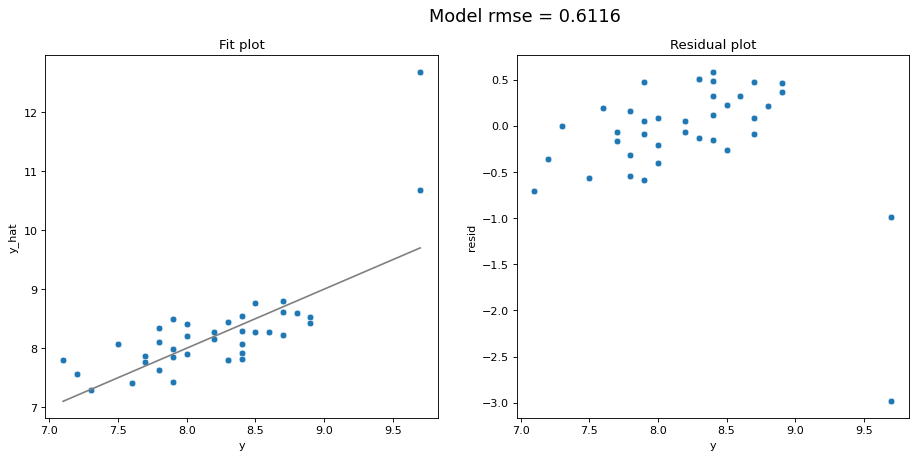

rmse_test ==  0.6116484519563747
rmse_train ==  0.0
coefficients ==  [ 8.21758464e+00  2.49516265e-01  4.23032207e-01  7.31450808e-02
 -3.03099286e-02  2.60256859e-02  9.54185131e-03 -2.99855263e-02
  8.15237516e-02  2.28778543e-02 -1.95420453e-02 -1.37213337e-01
  4.86521322e-02  1.00219768e-01 -5.96953099e-03  1.89626328e-02
 -6.34403329e-03 -2.00989566e-02  6.60877115e-02  7.56809936e-04
 -2.50396887e-02  4.46796842e-03 -2.87934369e-02 -1.48464074e-03
 -5.89274649e-02 -5.27549180e-02 -2.86875778e-02  3.27917572e-03
 -4.22881056e-02 -4.10709959e-02 -3.54010043e-02 -4.29289673e-02
  2.44939785e-02  2.29438352e-02 -3.26717475e-02  2.33862103e-02
 -3.85193401e-03  8.37980492e-03 -1.18907907e-02  1.41265175e-02
  1.56416432e-02  2.51171446e-02  2.19408148e-02  3.49715554e-02
 -1.37767542e-02 -5.45223517e-02 -1.17688782e-01 -7.79118858e-02
 -1.40036219e-02  1.23733329e-01  5.44205562e-02  7.05226363e-02
  4.46778059e-02 -1.18314709e-01  2.64505562e-02  8.07969966e-03]
intercept ==  0.0


In [ ]:
poly_reg_ridge, rmse_train_poly_reg_ridge, rmse_test_poly_reg_ridge = run_ridge_(df_model_data)

## Run models for full data set:(for baseline comparison)

best index:  0
best param:  {'linearregression__normalize': True}
best neg_root_mean_squared_error (score):  1.308421100830424
number of coefficients: 139


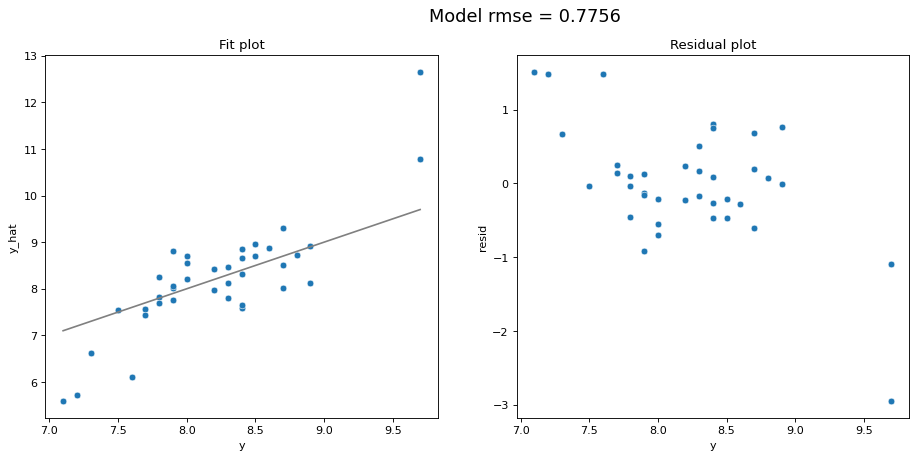

rmse_test ==  0.7756383994082989
rmse_train ==  0.0
[ 4.66264773e-02  6.97821133e-04  2.60324933e-03 -7.00330040e-04
 -6.16893853e-05 -1.15638825e-02 -4.89503592e-02  3.25090531e+00
  2.03986184e+00 -1.90116803e-01  2.33285041e-01 -3.65284620e-02
 -1.66074550e+00 -8.96545303e-02 -1.56434538e-01  9.30736313e-02
  2.25452298e-01 -8.94270796e-02  5.34509998e-02 -5.15408184e-02
  1.12643491e-01  1.27203615e-01 -5.13402390e-02  5.49560397e-15
 -2.57571742e-14 -1.80541529e-01  1.42534000e-01  3.29161877e-01
  4.27377456e-01  8.71855777e-01  1.89518651e-01 -2.27974959e-01
 -1.22715410e-01 -2.40916938e+00 -9.52680009e-01 -3.96086953e-01
  1.07021406e-03 -1.36473341e-01  4.58650217e-01  2.07484711e-01
 -1.85966918e-01 -1.54114571e+00  1.10585797e-01 -8.69924371e-02
 -5.10136589e-02  8.33268963e-02  2.44249065e-15  3.06571246e-01
 -5.06687705e-02  7.25930036e-01  6.39212225e-01 -9.53527862e-02
  6.12263921e-01  3.45909172e-01  6.14505375e-01  3.24751829e-01
  1.05634344e+00  1.77242416e-02 -9.99

In [ ]:
lin_reg_full,rmse_train_lin_reg_full,rmse_test_lin_reg_full = run_linear_regression(df_full_dummies)



In [ ]:
#lin_reg_stand_c, rmse_train_lin_stand_c, rmse_test_lin_stand_c= run_linear_regr_standardisation(df_full_dummies)


best index:  24
best param:  {'columntransformer__polynomialfeatures-1__degree': 1, 'columntransformer__polynomialfeatures-2__degree': 2, 'columntransformer__polynomialfeatures-3__degree': 2, 'columntransformer__polynomialfeatures-4__degree': 1, 'columntransformer__polynomialfeatures-5__degree': 1, 'columntransformer__polynomialfeatures-6__degree': 1}
best score:  1.2475190953701811
number of coefficients: 141


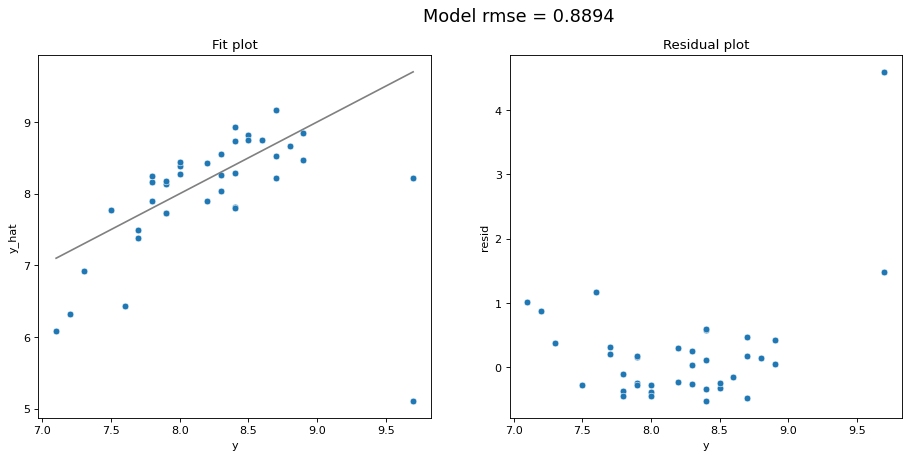

rmse_test ==  0.8894327636365652
rmse_train ==  0.0
[ 3.14773892e-02  2.10647864e-03 -2.75306021e-07  5.36178639e-04
  3.75004933e-06  2.24768955e-04 -1.78374713e-04  1.96700338e-03
 -2.31305051e-02  2.96556012e+00  2.07043664e+00 -3.72314800e-01
  2.41361465e-01 -1.04249572e-02 -1.09116568e+00 -1.05523342e-01
 -1.75928497e-01  3.24316929e-02  2.03676743e-01 -2.59604795e-02
 -1.40265848e-02 -2.92880103e-02  8.39068928e-02  9.71451836e-02
  4.89488996e-02  4.95159469e-14  1.20903287e-13 -1.77461590e-01
  2.01758236e-01  3.10826609e-01  4.77503382e-01  8.34386211e-01
  1.14230886e-01 -3.04291836e-01  8.95564961e-02 -1.82051870e+00
 -7.91636241e-01 -4.98492471e-01  9.60372404e-02 -1.13478487e-01
  3.73116886e-01  3.27050969e-01 -6.72018436e-02 -7.72707742e-01
  1.92500598e-01 -3.43569019e-02 -3.82006356e-02 -2.19077054e-02
 -2.60902411e-15  2.48401528e-01 -1.42128107e-01  5.21141988e-01
  4.12487982e-01  5.31867642e-02  2.46255012e-01  2.65375510e-01
  4.51649433e-01  1.48362379e-01  7.24

In [ ]:
poly_reg_noint_c, rmse_train_poly_reg_noint_c, rmse_test_poly_reg_noint_c= run_poly_noint(df_full_dummies)


best index:  1
best param:  {'linearregression__normalize': True, 'polynomialfeatures__degree': 2}
best score:  0.8401580409425037
number of coefficients: 9870


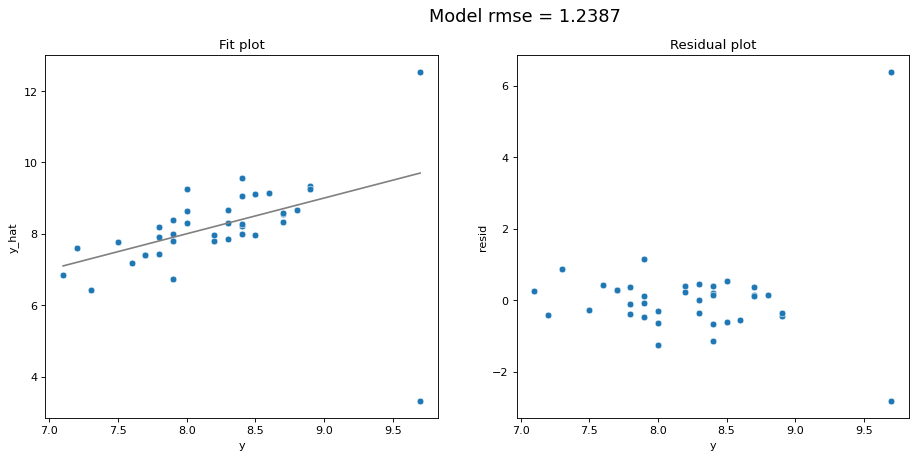

rmse_test ==  1.2386511739645087
rmse_train ==  0.0
[6.18965229e-07 8.78604459e-07 7.25153551e-04 ... 4.68904974e-07
 0.00000000e+00 1.02593441e-07]
intercept ==  0.0


In [ ]:
poly_reg_c, rmse_train_poly_reg_c, rmse_test_poly_reg_c=run_polynomial_regression(df_full_dummies)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8843016104762647, tolerance: 0.812053
  positive)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8555540463703626, tolerance: 0.808377
  positive)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.167279173615297, tolerance: 0.808377
  positive)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

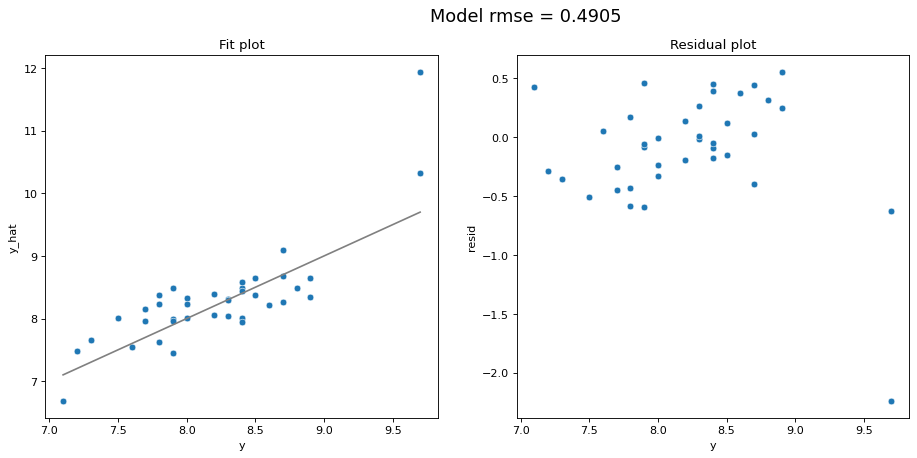

rmse_test ==  0.49046034383642434
rmse_train ==  0.0
coefficients ==  [ 8.25013514e+00  6.93340049e-02  3.36822206e-01  1.12793911e-01
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -3.04640222e-02
  0.00000000e+00  9.48629249e-02 -6.64273246e-03  4.37754316e-02
 -0.00000000e+00 -0.00000000e+00 -1.99997170e-03 -4.71359228e-02
  3.21421589e-03  4.71094737e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.92782882e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.28476219e-03 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  2.62332669e-03  1.05024231e-02 -1.69824767e-02 -7.56774844e-02
 -8.21301210e-03 -1.96442633e-02 -0.00000000e+00 -1.41146153e-02
  1.35655265e-02 -5.19675631e-03 -0.00000000e+00 -1.22381844e-02
  1.73666511e-03  1.87823159e-02  1.81117374e-02  0.00000000e+00
  1.77575841e-02 -0.00000000e+00  0.00000000e+00  3.06300192e-03
 -1.18340930e-02  0.00000000e+00 -0.00000000e+00  1.99827222e-02
  4.71367599e-03  4.

In [ ]:
poly_reg_lasso_c, rmse_train_poly_reg_lasso_c, rmse_test_poly_reg_lasso_c= run_lasso_(df_full_dummies)


best index:  100
best param:  {'polynomialfeatures__degree': 1, 'ridge__alpha': 3.2550885998350596}
best score:  0.5793968888469763
number of coefficients: 140


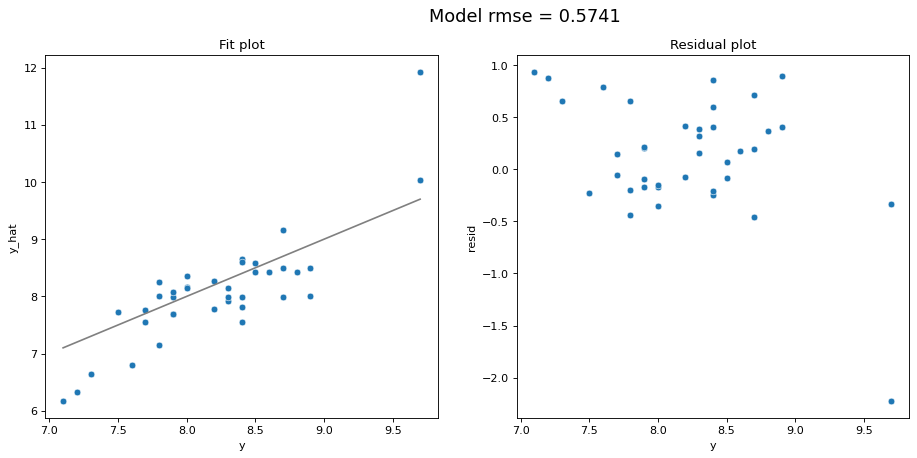

rmse_test ==  0.5740615588084241
rmse_train ==  0.0
coefficients ==  [ 8.08237271e+00  1.54736142e-01  3.35057211e-01  1.74950192e-01
 -1.89679830e-02 -2.19641166e-02  1.46887613e-02 -3.32541490e-02
  0.00000000e+00  4.29348136e-02 -3.16527016e-02  6.81423665e-02
 -1.71106572e-02 -9.03594361e-02 -3.45401003e-02 -6.68087855e-02
  3.59319729e-02  7.58050781e-02 -2.45225544e-03  7.97744945e-03
 -5.24303829e-02  2.52711104e-02  5.04653082e-02 -1.36766696e-02
  0.00000000e+00  0.00000000e+00 -2.85820843e-02  6.32377811e-03
  1.38767773e-02  2.52241307e-02  3.06293871e-02  4.10248182e-03
 -1.34807390e-04 -1.80712896e-03 -8.13400389e-02 -7.95313853e-02
 -3.62315264e-02 -2.81736113e-02 -1.36530366e-02  2.02230655e-02
  1.59069485e-02 -1.14783662e-02 -5.55364762e-02 -1.40852641e-02
  2.70444166e-03  2.12628688e-02  2.16779003e-02  0.00000000e+00
  2.94591369e-02 -2.40332617e-02  5.39728048e-02  2.77934001e-02
 -2.87974200e-02  3.45664632e-02 -7.16317309e-03  3.04637607e-02
  1.52807207e-02  2.5

In [ ]:
poly_reg_ridge_c, rmse_train_poly_reg_ridge_c, rmse_test_poly_reg_ridge_c= run_ridge_(df_full_dummies)

### Model Error Comparisons 
We can evaluate the models erros and compare against one another. 


In [ ]:

def get_CI(y,y_hat):
    '''
    y = Input target variable
    y_hat = Output test 
    Returns a test_error, standard_error rounded to 3 dp. 
    '''
    mean_error = np.mean(abs(y-y_hat)) 
    standard_error = np.sqrt(np.var(mean_error,ddof=1)/(len(abs(y)))
    #confidence intervals
    CI = mean_error + np.array([- 2*standard_error,2*standard_error])
    
    return CI
    #return round(test_error,3), round(standard_error,3)

RSS = ((y - y_hat) ** 2).sum()

sigma_hat = np.sqrt(RSS/(len(y)-(len(X.columns)+1)))



In [ ]:
y_hat = model.predict(X)
residuals = y.values - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

In [ ]:
te_lass, se_lass = get_SandT_Error(y,y_hat)


error_df = pd.DataFrame.from_dict({"model": ['Lasso', 'Ridge', 'NB'],
                                    "Train_error":[0,0,0],
                                    "Test_error": [0,0,0],
                                    "Train_CE_error": [0,0,0],
                                    "Test_CE_error": [0,0,0]})
c = 1
b = 2

a = c, b



error_df[error_df['model'] == 'Lasso']

SyntaxError: invalid syntax (<ipython-input-107-493ebc606e38>, line 15)

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

##### Directors & writers
There are a large number of episodes which were written or directed by multiple people in collabouration with one another. Also, as seasons go on, some new writers/directors appear. 

There are many unique writers and directors, and some combinations in the data set, i.e. on one episode, director A and director B worked together. As it is impossible to determine the influence of the individual in these cases as we do not who 'who did what', it is assumed here that director AB is a different 'person', and extra credit is not givento directors A and B individually. This further ensures that only one director is attributed to any episode. 
In order to work with finding out whether a writer or director is correlated with an increasing imdb rating, more than one data point is needed. As such, we have chosen to omit from the data, any writer or director that appears only once.

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

### 4.1 Model evaluation and interpretation

A Lasso Regression model was selected for this report; The decision to select Lasso regression was a result of various combinations of models and datasets experimented on to provide the most accurate model for predicting the best rated episode. 

#### 4.1.1 Datasets 
As explained in the feature engineering section of the report, there were features eliminated from the dataset because these would not help with model accuracy and would require unnecessary additional processing time. The predictive models were run with the full dataset as a baseline, and with the features removed as identified in the feature engineering stage of the report. This gave reassurance to assumptions made in the feautring engineering stage  when tuning the model.


#### 4.1.2 Model exploration 
A Regular linear regression model produced a reasonable model with an RMSE of 0.6376, this outperformed polynomial models which were interrogated both with and without interactions between features. The Polynomial models provided a best fit of 1 degree for all features a part from 1 within the reduced dataset. This suggested that a linear regression model was the superior model to further explore. 

A Lasso & Ridge regression model were both investigated. Lasso provided the lowest Alpha, as well as the lowest RMSE of all models explored, and gace clarity on many columns which were non-influential to predicting a highly rated episode. Because Lasso Regression was found to be the most accurate and best performing model, this is the chosen model for the report. 

|  model |  | RMSE   | best fit  | Coefs| Other| Comment| 
|---|---|---|---|---|---|---|---|---|---|
|  Normal Linear |   |  0.637 |   |55  |
|  Normal Linear with standardisation|   |  8.1015 |   |55  |
|  Polynomial with no direction |   |  0.6433 |   | 56  |   |   |
|  Polynomial regression with no interactions |   |  0.6435 |   | 56  |   |   |
|  Polynomial regression |   |  0.6376 |  1 | 56  |   |   |
|  Linear Polynomial regression (using Full data - no feature engineering) |   |  0.7756 |   | 139  |   |   |
|  Polynomial regression with no interactions (using Full data - no feature engineering)|   |  0.8894 |   | 141  |   |   |
|  Polynomial regression (using Full data - no feature engineering)|   |  1.2387 |   | 9870  |   |   |
|  Other models  |--|--|--|--|--|--|--|
|  lasso |   |  0.5203 |    1 | 56  |  Alpha = 0.1 |   |   |
|  ridge |   |  0.6116 |     1 | 56  |  Alpha = 0.73 |   |   | 

### 4.2 Analysis of Coeficients
#### 4.2.1 Numerical Features

The number of words & number of speaking characters within an episode (n_words & n_speak_chars) were found to not correlate to the IMDB rating of an episode and the model reduced the coefficients of these features to zero. This is reassuring, given that in the feature engineering stage a number of characters were disregarded. From this we can interpret that performance/rating will not be influenced by a special edition episode that would aim to have all lots of characters “brought back”, nor would it benefit from conversations ensuring that all characters had to have meaningful lines. 

The number of episode, which increase throughout a season, was shown to be highly influential. This is logical to explain, as often writers will ensure that the season finale “ends on a high”, and ensures interest in the next season to come. We can see from the below plot that the highest rated episodes within a season come toward the end of the season (note, not all seasons are of the same length) .If one could entertain the idea, it would therefore be recommended that rather than NBC produce one single special edition, that a short special edition season was created, with the finale of this season expected to outperform all others. 


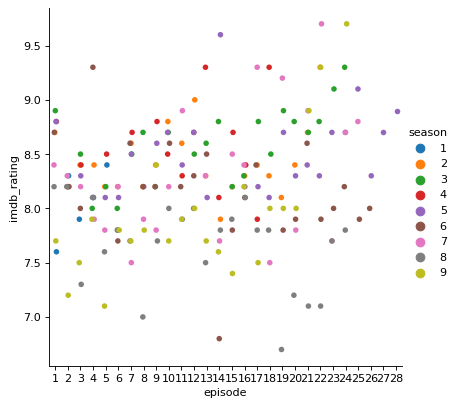

In [ ]:
sns.catplot(data = df, hue = 'season', x = 'episode', y = 'imdb_rating', )

An increase of total votes & number of directions within a episode were both found to me marginally influential in producing a higher rated episode, to a similar extent. It should be noted that NBC will not be in control of the number of votes cast on IMDB, therefore this feature is not reliable, but it is recommended that NBC encourage viewers to make reviews as these appear to be favourable. The number of lines. The number of directions is however not as important as the number of lines within the episode, therefore ensuring that the number of lines is prioritised over the directions within the episode will ensure a better rating. 

#### 4.2.2 Binomial Features
Fields which have been direived from text data in the feature engineering stage 

It is suggested that NBC show the special edition episode on a Thursday; as its been shown that Sundays viewing tend to provide a negative relationship with how the shows are rated. There is no coefficient for viewing on a Tuesday, and a negative coefficient for Sunday viewings, therefore the small influence that Thursdays do have shall gives the episode a marginal advantage. 

There is no correlation to airing a show in January or October, however the model suggests that airing the show between February and April results in less favourable rating. Therefore the show should be aired withing either May or September (which has the highest positive coefficient), but not necessarily within the month’s in-between as there have not been any episodes aired within these summer months. 

The following characters were found to have had no influence on an episode, and therefore could be dropped from the model are Phlylis, Ryan, Meredith, Creed and Andy. Therefore, it makes no difference whether these characters should be included in a special edition episode. NBC should note that Michael and Stanley
both have negative coefficient resulting from this model; Given that Michael is one of the most recognised characters within the whole “Office” franchise, this result may be challenged and we would not recommend strictly adhering to this recommendation. Screenrant have written an article suggesting (The Office: Every Character, Ranked By Likability | ScreenRant )that Michael is the top liked character in the series, therefore additional feature engineering would explored the popularity of characters more rigorously if further time was available. 


#### 4.2.3 Dropped Fields 



In [ ]:
coeff_reg_lasso

NameError: name 'coeff_reg_lasso' is not defined

In [ ]:

pd.DataFrame(results = {'Model': ['Liner regression', 'Normal Linear with standardisation', 
                    'Polynomial with no direction ', 'Polynomial regression with no interactions',
                    'Polynomial regression', 'Linear Polynomial regression (Full Data)', 'Polynomial regression with no interactions (Full Data)',
                    'Polynomial regression (Full Data)','Lasso', 'Ridge'],
    'Train_RMSE': [rmse_train_lin_reg_df_model_data,rmse_train_lin_stand,0,rmse_train_poly_reg_noint,rmse_train_poly_reg,0,0,0,rmse_train_poly_reg_lasso,rmse_train_poly_reg_ridge],
	'Test_RMSE': [rmse_test_lin_reg_df_model_data, rmse_test_lin_stand,0,rmse_test_poly_reg_noint,rmse_test_poly_reg,0,0,0,rmse_test_poly_reg_lasso,rmse_test_poly_reg_ridge],
	'CI': [0,0,0,0,0,0,0,0,0,0]})

    #rmse_train_lin_stand, rmse_test_lin_stand, 
    #rmse_train_poly_reg_noint, rmse_test_poly_reg_noint,
    #rmse_train_poly_reg, rmse_test_poly_reg, 
    #rmse_train_poly_reg_lasso, rmse_test_poly_reg_lasso,
    #rmse_train_poly_reg_ridge, rmse_test_poly_reg_ridge, 
    #rmse_train_lin_reg_full,rmse_test_lin_reg_full

NameError: name 'rmse_train_lin_reg_kk' is not defined

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

Things still to do:

1) write about justifying the results we got from all of our models (Lasso using df_model_data, the reduced dataframe)
    
    * How we were able to get ride of so many "0" features. Which features have been dropped, and what this means. 
    * which are the most/least important features. 
    
2) Renaming Dataframes & parameters... 

## 5. Convert Document

In [ ]:
# # Run the following to render to PDF
# !jupyter nbconvert --to markdown project1.ipynb # I dont think this one will work?
# !jupyter nbconvert --to pdf project1.ipynb
# To hide code:
# jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True my_notebook.ipynb

Text(0.5, 1.0, 'Number of occurrences for each character')

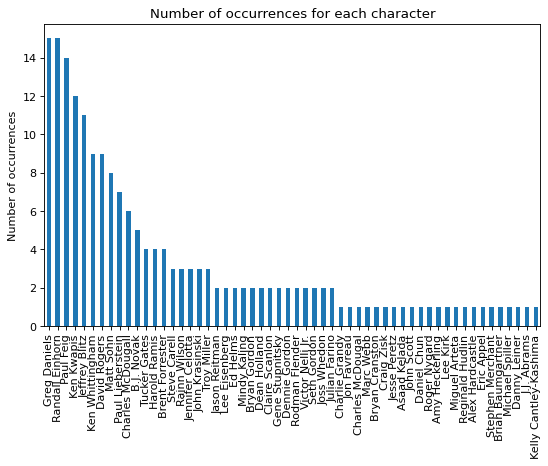

In [28]:
dirs = pd.concat([df[['season','episode']],df['director'].str.rsplit(";", n=-1, expand=True)], axis = 1)
melted_dirs = dirs.melt(id_vars = ['season','episode'], value_name = 'directors').drop('variable',axis = 1).dropna()
melted_dirs['directors'].value_counts(normalize=False).plot(kind='bar')
plt.ylabel('Number of occurrences')
plt.title('Number of occurrences for each character')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d54bbee-a4bc-40dc-a5f1-a0190c0e14b4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>